In [1]:
library(tidyverse)
library(repr)
library(tidymodels)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [5]:
# reading in data
players_data<- read_csv("players.csv") |>
               mutate(gender = as_factor(gender))

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<lgl>,<lgl>
Beginner,TRUE,f9ac013b2f0bc2bd4928a6a0fc8a0aae8b5c4f2670cf9e18f547b7e72034c965,1,Leah,Male,17,NA,NA
Pro,TRUE,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,1,Knox,Male,17,NA,NA
Veteran,TRUE,cb00c16dc2043f435a7a8c2a473656e4119ffa7173bab7ec7455715173912498,1,Suki,Non-binary,17,NA,NA
Beginner,TRUE,ae8d8a9dcf80b38466f89466201e6d594eb94d6994eda1617f7dfae9cb21bfb3,1,Ella,Female,17,NA,NA
Beginner,TRUE,6ca8a90e4f5c61bf36baf556d446873c4e894e7a62f91996aa237be64b0e183b,1,Atlas,Female,17,NA,NA
Amateur,FALSE,7096b30972a32029244fc6171f21bc5996b51b8d75df7a94f003dead428988f9,1,Radwan,Male,26,NA,NA


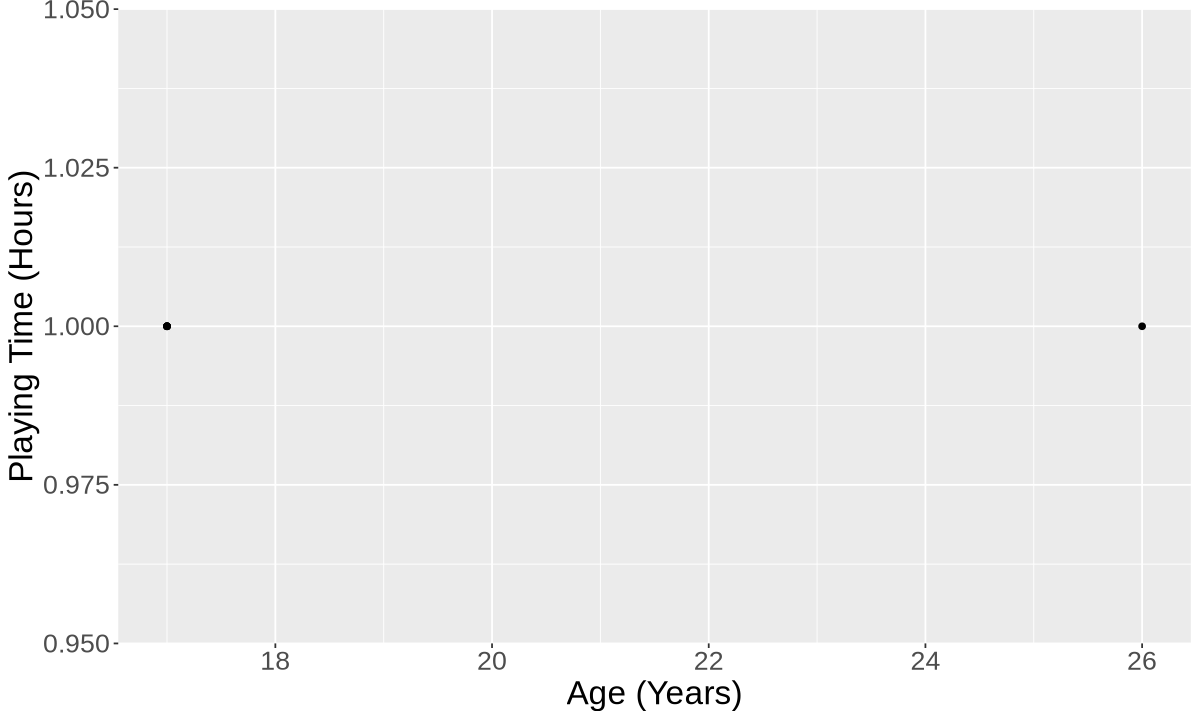

In [9]:

options(repr.plot.width=10, repr.plot.height=6)

players_data_filtered <- filter(players_data, played_hours ==! 0)

players_data_filtered |> 
       ggplot(aes(x = age, y = played_hours), colour = gender) +
       labs(x = "Age (Years)", 
            y = "Playing Time (Hours)",
           colour = "Gender") +
       geom_point() +
       theme(text = element_text(size = 20))

players_data_filtered